## Chapter 9 - Hierarchical Models

- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   
    - [Shrinkage](#Shrinkage)
- [9.5.1 - Example: Baseball batting abilities by position (subjects within categories)](#9.5.1---Example:-Baseball-batting-abilities-by-position)   

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import Image
from matplotlib import gridspec

%matplotlib inline

plt.style.use('seaborn-white')
color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p arviz,matplotlib,numpy,pandas,pymc,seaborn

arviz     : 0.11.4
matplotlib: 3.5.1
numpy     : 1.22.3
pandas    : 1.4.1
pymc      : 4.0.0b6
seaborn   : 0.11.2



### 9.2.3 - Example: Multiple Coins form a Single Mint

In [3]:
# data from coin #1
n_heads1 = 3
n_tails1 = 12

n_flips1 = n_heads1 + n_tails1
data1 = np.repeat([1, 0], [n_heads1, n_tails1])

# coin #2
n_heads2 = 4
n_tails2 = 1

n_flips2 = n_heads2 + n_tails2
data2 = np.repeat([1, 0], [n_heads2, n_tails2])

# now pack all those outcomes into a single vector
outcomes = np.hstack((data1, data2))
# and create a vector of 'coin IDs' so that we can connect each flip
# with the corresponding coin's value of theta
coin = np.hstack((np.zeros_like(data1), np.ones_like(data2)))

In [4]:
# build the model
with pm.Model() as oneminttwocoins_model:
    omega = pm.Beta('omega', 2., 2.)
    # Kruschke uses these parameters in the chapter, but they yield very poor sampling
    #kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa_minus2 = pm.Gamma('kappa_minus2', .5, .5)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)

    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=2)
        
    y = pm.Bernoulli('y', theta[coin], observed=outcomes)

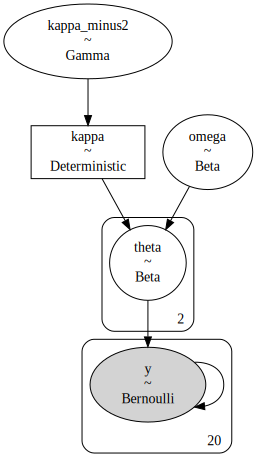

In [5]:
pm.model_to_graphviz(oneminttwocoins_model)

In [6]:
# sample!
with oneminttwocoins_model:
    idata_1m2c = pm.sample(5000, chains=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/xian/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 38 seconds.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

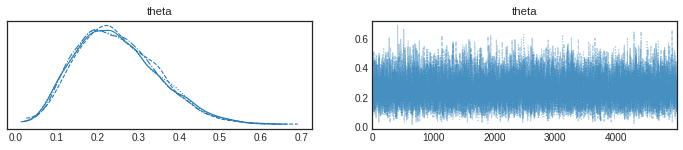

In [7]:
az.plot_trace(idata_1m2c, var_names=['theta'], coords={"theta_dim_0": [0]})

In [8]:
az.summary(idata_1m2c)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.492,0.215,0.099,0.873,0.002,0.001,15080.0,11387.0,1.0
kappa_minus2,0.888,1.217,0.000,3.021,0.011,0.008,7957.0,7001.0,1.0
theta[0],0.247,0.100,0.074,0.435,0.001,0.001,12878.0,11224.0,1.0
theta[1],0.690,0.162,0.404,0.971,0.001,0.001,12091.0,9831.0,1.0
kappa,2.888,1.217,2.000,5.021,0.011,0.008,7957.0,7001.0,1.0


In [9]:
idata_1m2c.posterior['omega'].sel(draw=0)

<xarray.DataArray 'omega' (chain: 4)>
array([0.29236803, 0.52305571, 0.40971096, 0.55934999])
Coordinates:
  * chain    (chain) int64 0 1 2 3
    draw     int64 0

Given that this is our first legitimate MCMC trace object, let's see how one can interogate the raw trace to extract information we might want.

In [10]:
idata_1m2c

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [11]:
# let's look at the first MCMC sample
idata_1m2c.posterior.sel(draw=0, chain=0)

<xarray.Dataset>
Dimensions:       (theta_dim_0: 2)
Coordinates:
    chain         int64 0
    draw          int64 0
  * theta_dim_0   (theta_dim_0) int64 0 1
Data variables:
    omega         float64 0.2924
    kappa_minus2  float64 5.461
    theta         (theta_dim_0) float64 0.3109 0.302
    kappa         float64 7.461
Attributes:
    created_at:                 2022-05-04T04:02:28.105299
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b6
    sampling_time:              37.89756774902344
    tuning_steps:               1000

Note that there are **2** values of theta in this first step (one for each coin).  They are stored together, because we asked for an array of theta parameters.  Let's calculate the mean value of the $\theta$ parameter associated with the first coin.

In [12]:
idata_1m2c.posterior['theta'].mean(dim=['draw','chain'])[0]

<xarray.DataArray 'theta' ()>
array(0.24738438)
Coordinates:
    theta_dim_0  int64 0

And for the second coin.

In [13]:
idata_1m2c.posterior['theta'].mean(dim=['draw','chain'])[1]

<xarray.DataArray 'theta' ()>
array(0.69036699)
Coordinates:
    theta_dim_0  int64 1

What if we have 'reference' values against which we wish to compare our parameter estimate?  We can, among other things, ask what proportion of samples took on a value greater than/less than that reference value.  In the case of coins, which might wish to compare $\theta$ to a value of 0.5 (i.e., to ask how likely it is that each coin is 'fair').

In [14]:
# coin 1
(idata_1m2c.posterior['theta']>.5).mean(dim=['draw','chain'])[0]

<xarray.DataArray 'theta' ()>
array(0.01235)
Coordinates:
    theta_dim_0  int64 0

In [15]:
# coin 2
(idata_1m2c.posterior['theta']>.5).mean(dim=['draw','chain'])[1]

<xarray.DataArray 'theta' ()>
array(0.8629)
Coordinates:
    theta_dim_0  int64 1

Now let's ask about our mint parameter, $\omega$.  Here too we calculate the mean posterior estimate.

In [16]:
idata_1m2c.posterior['omega'].mean(dim=['draw','chain'])

<xarray.DataArray 'omega' ()>
array(0.49177167)

We can also again compare $\omega$ against our 'reference' value of 0.5.  The interpretation of $\omega$ is somewhat different than the interpretation of $\theta$.  Asking about $p(\omega > 0.5)$ tells us whether the _mint tends to generate fair coins_.

In [17]:
(idata_1m2c.posterior['omega']>.5).mean(dim=['draw','chain'])

<xarray.DataArray 'omega' ()>
array(0.4784)

We can also inspect $\kappa$, which will tell us how consistent the mint is in generating coins with values of $\theta$ near $\omega$.

In [18]:
idata_1m2c.posterior['kappa'].mean(dim=['draw','chain'])

<xarray.DataArray 'kappa' ()>
array(2.88807304)

### 9.2.4 - Example: Therapeutic touch

In [19]:
df = pd.read_csv('data/TherapeuticTouchData.csv', dtype={'s':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   y       280 non-null    int64   
 1   s       280 non-null    category
dtypes: category(1), int64(1)
memory usage: 2.8 KB


In [20]:
df.head()

,y,s
0,1,S01
1,0,S01
2,0,S01
3,0,S01
4,0,S01


#### Figure 9.9

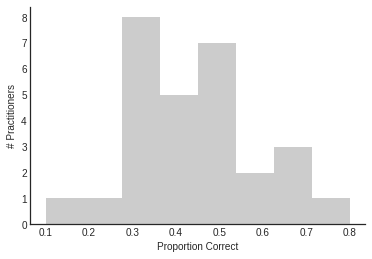

In [21]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = sns.distplot(df_proportions, bins=8, kde=False, color='gray')
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners')
sns.despine(ax=ax);

#### Model (Kruschke, 2015)

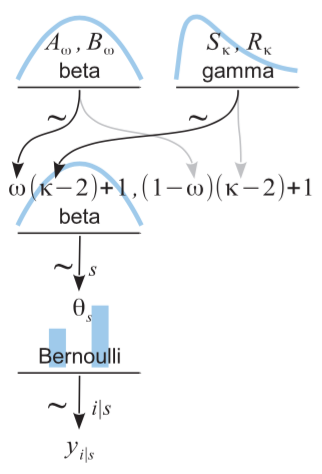

In [22]:
Image('images/fig9_7.png', width=200)

In [23]:
practitioner_idx = df.s.cat.codes.values
practitioner_codes = df.s.cat.categories
n_practitioners = practitioner_codes.size

with pm.Model() as therapeutictouch_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', theta[practitioner_idx], observed=df['y'])

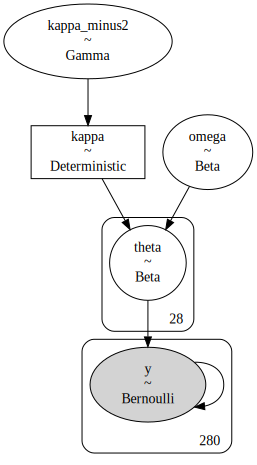

In [24]:
pm.model_to_graphviz(therapeutictouch_model)

In [25]:
with therapeutictouch_model:
    idata_tt = pm.sample(5000, chains=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/xian/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 76 seconds.


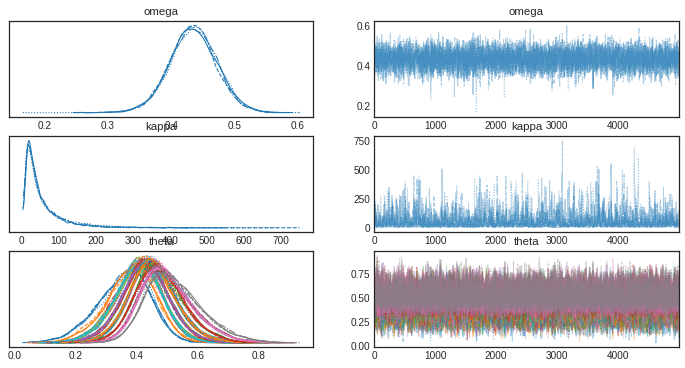

In [26]:
az.plot_trace(idata_tt, var_names=['omega','kappa', 'theta']);

In [27]:
az.summary(idata_tt)
# Note that theta is indexed starting with 0 and not 1, as is the case in Kruschke (2015).

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.434,0.037,0.365,0.504,0.000,0.000,6202.0,10715.0,1.0
kappa_minus2,54.469,58.421,1.361,157.047,1.444,1.021,1538.0,2918.0,1.0
theta[0],0.359,0.087,0.183,0.506,0.001,0.001,4644.0,7534.0,1.0
theta[1],0.383,0.083,0.219,0.532,0.001,0.001,6846.0,9169.0,1.0
theta[2],0.407,0.080,0.252,0.556,0.001,0.001,12126.0,9441.0,1.0
theta[3],0.406,0.080,0.253,0.559,0.001,0.001,11509.0,9307.0,1.0
theta[4],0.406,0.081,0.254,0.565,0.001,0.001,12293.0,9005.0,1.0
theta[5],0.406,0.080,0.246,0.553,0.001,0.001,11426.0,10350.0,1.0
theta[6],0.406,0.079,0.250,0.552,0.001,0.001,11619.0,10260.0,1.0
theta[7],0.406,0.081,0.242,0.553,0.001,0.001,12004.0,10442.0,1.0


#### Figure 9.10 - Marginal posterior distributions

In [28]:
idata_tt.posterior['theta'].mean(dim=['chain', 'draw']).sel(theta_dim_0=0)

<xarray.DataArray 'theta' ()>
array(0.35882313)
Coordinates:
    theta_dim_0  int64 0

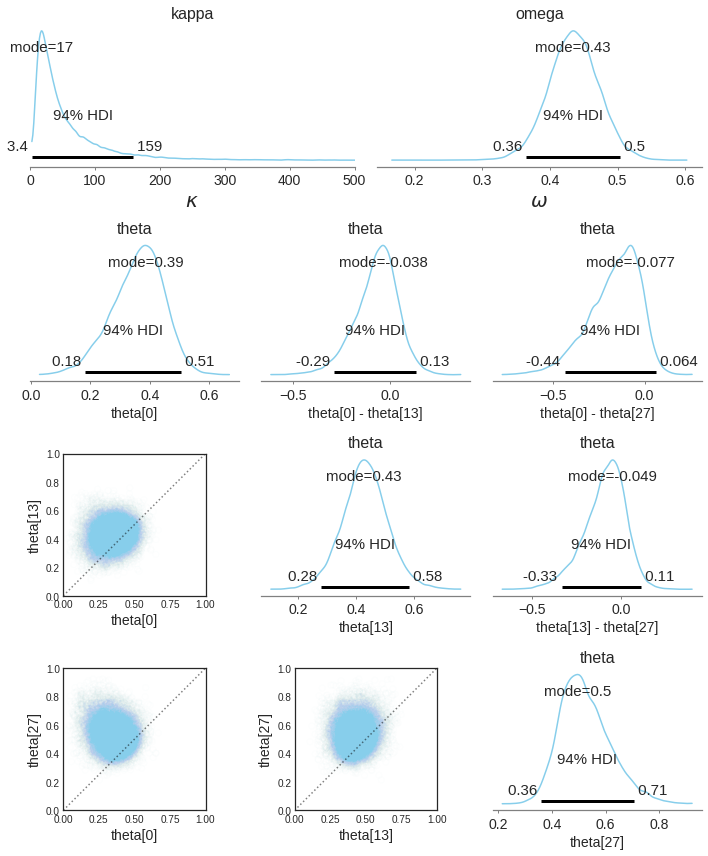

In [29]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

# thetas and theta pairs to plot
thetas = (0, 13, 27)
theta_pairs = ((0,13),(0,27),(13,27))

font_d = {'size':14}

# kappa & omega posterior plots
for var, ax in zip(['kappa', 'omega'], [ax1, ax2]):
    az.plot_posterior(idata_tt.posterior[var], point_estimate='mode', ax=ax, color=color, round_to=2)
    ax.set_xlabel('$\{}$'.format(var), fontdict={'size':20, 'weight':'bold'})
ax1.set(xlim=(0,500))

# theta posterior plots
for var, ax in zip(thetas,[ax3, ax7, ax11]):
    #az.plot_posterior(trace['theta'][:,var], point_estimate='mode', ax=ax, color=color)
    #az.plot_posterior(trace['posterior']['theta'][:,var], point_estimate='mode', ax=ax, color=color)
    az.plot_posterior(idata_tt.posterior['theta'].sel(theta_dim_0=var), point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}]'.format(var), fontdict=font_d)

# theta scatter plots
for var, ax in zip(theta_pairs,[ax6, ax9, ax10]):
    #ax.scatter(trace['posterior']['theta'][::10,var[0]], trace['posterior']['theta'][::10,var[1]], alpha=0.75, color=color, facecolor='none')
    ax.scatter(idata_tt.posterior['theta'].sel(theta_dim_0=var[0]), idata_tt.posterior['theta'].sel(theta_dim_0=var[1]), alpha=0.02, color=color, facecolor='none')
    ax.plot([0, 1], [0, 1], ':k', transform=ax.transAxes, alpha=0.5)
    ax.set_xlabel('theta[{}]'.format(var[0]), fontdict=font_d)
    ax.set_ylabel('theta[{}]'.format(var[1]), fontdict=font_d)
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal')

# theta posterior differences plots
for var, ax in zip(theta_pairs,[ax4, ax5, ax8]):
    az.plot_posterior(idata_tt.posterior['theta'].sel(theta_dim_0=var[0])-idata_tt.posterior['theta'].sel(theta_dim_0=var[1]), point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}] - theta[{}]'.format(*var), fontdict=font_d)

plt.tight_layout()

### Shrinkage

Let's create a model with just the theta estimations per practitioner, without the influence of a higher level distribution. Then we can compare the theta values with the hierarchical model above.

In [30]:
with pm.Model() as unpooled_model:
    
    theta = pm.Beta('theta', 1, 1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', theta[practitioner_idx], observed=df['y'])

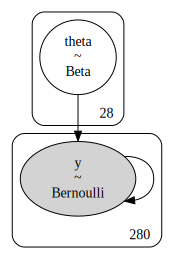

In [31]:
pm.model_to_graphviz(unpooled_model)

In [32]:
with unpooled_model:
    unpooled_idata = pm.sample(5000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.


Here we concatenate the trace results (thetas) from both models into a dataframe. Next we shape the data into a format that we can use with Seaborn's pointplot.

In [33]:
df_shrinkage = (pd.concat([az.summary(unpooled_idata).iloc[:,0],
                           az.summary(idata_tt).iloc[2:-1,0]],
                          axis=1)
                .reset_index())
df_shrinkage.columns = ['theta', 'unpooled', 'hierarchical']
df_shrinkage = pd.melt(df_shrinkage, 'theta', ['unpooled', 'hierarchical'], var_name='Model')
df_shrinkage.head()

,theta,Model,value
0,theta[0],unpooled,0.166
1,theta[1],unpooled,0.251
2,theta[2],unpooled,0.333
3,theta[3],unpooled,0.334
4,theta[4],unpooled,0.332


The below plot shows that the theta estimates on practitioner level are pulled towards the group mean of the hierarchical model.

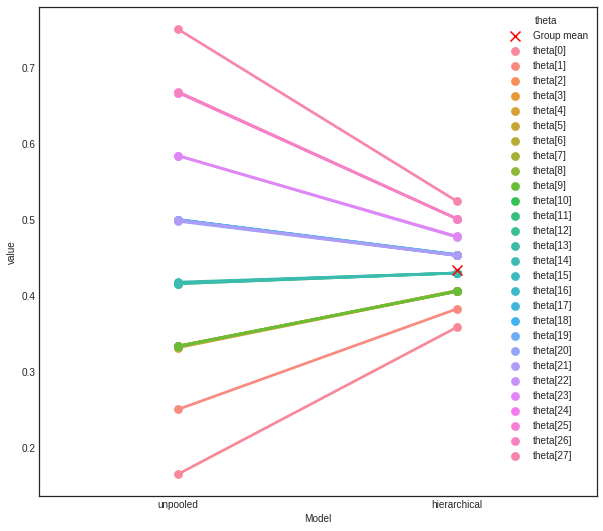

In [34]:
plt.figure(figsize=(10,9))
plt.scatter(1, az.summary(idata_tt).iloc[0,0], s=100, c='r', marker='x', zorder=999, label='Group mean')
sns.pointplot(x='Model', y='value', hue='theta', data=df_shrinkage);

### 9.5.1 - Example: Baseball batting abilities by position

In [35]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Player  948 non-null    object  
 1   PriPos  948 non-null    category
 2   Hits    948 non-null    int64   
 3   AtBats  948 non-null    int64   
dtypes: category(1), int64(2), object(1)
memory usage: 23.6+ KB


The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [36]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head(10)

,Player,PriPos,Hits,AtBats,BatAv
0,Fernando Abad,Pitcher,1,7,0.142857
1,Bobby Abreu,Left Field,53,219,0.242009
2,Tony Abreu,2nd Base,18,70,0.257143
3,Dustin Ackley,2nd Base,137,607,0.225700
4,Matt Adams,1st Base,21,86,0.244186
5,Nathan Adcock,Pitcher,0,1,0.000000
6,Jeremy Affeldt,Pitcher,0,1,0.000000
7,Brandon Allen,1st Base,2,20,0.100000
8,Yonder Alonso,1st Base,150,549,0.273224
9,Jose Altuve,2nd Base,167,576,0.289931


In [37]:
# Batting average by primary field positions calculated from the data
df2.groupby('PriPos')['Hits','AtBats'].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

#### Model (Kruschke, 2015)

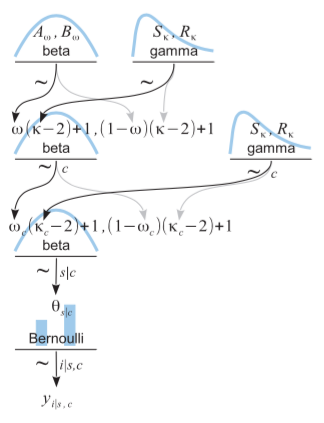

In [38]:
Image('images/fig9_13.png', width=300)

In [39]:
pripos_idx = df2.PriPos.cat.codes.values
pripos_codes = df2.PriPos.cat.categories
n_pripos = pripos_codes.size

# df2 contains one entry per player
n_players = df2.index.size

with pm.Model() as hierarchical_model2:
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Parameters for categories (Primary field positions)
    omega_c = pm.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = n_pripos)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
        
    # Parameter for individual players
    theta = pm.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1,
                    (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y2 = pm.Binomial('y2', n=df2.AtBats.values, p=theta, observed=df2['Hits'])

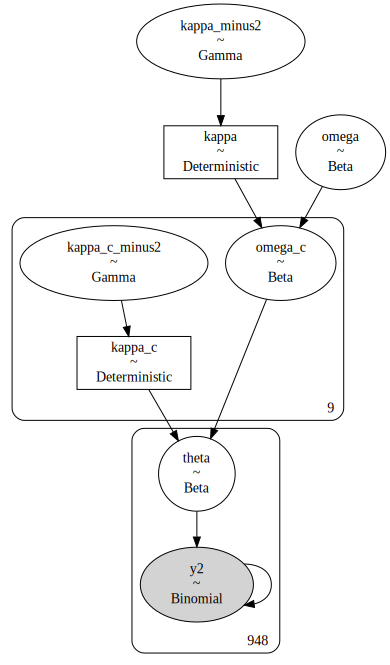

In [40]:
pm.model_to_graphviz(hierarchical_model2)

In [41]:
with hierarchical_model2:
    idata2 = pm.sample(2000, chains=4, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/xian/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [omega, kappa_minus2, omega_c, kappa_c_minus2, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 175 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


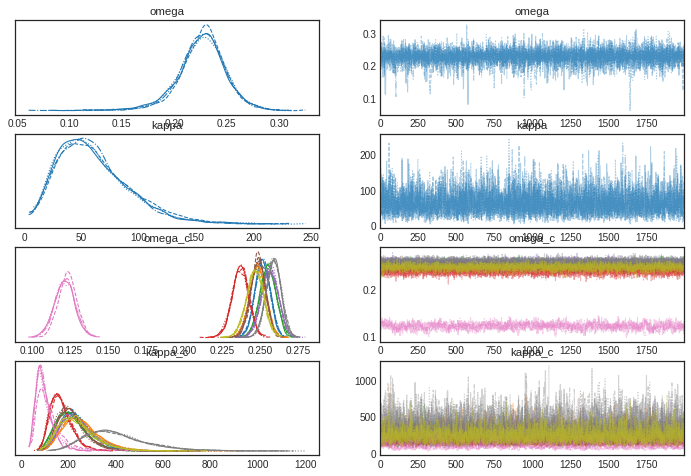

In [42]:
az.plot_trace(idata2, var_names=['omega', 'kappa', 'omega_c', 'kappa_c']);

#### Figure 9.17

#### Posterior distribution of hyper parameter omega after sampling.

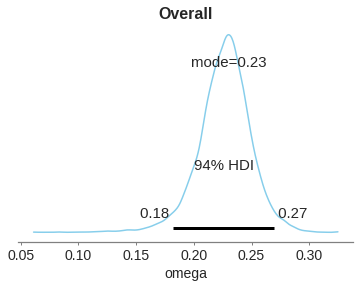

In [43]:
az.plot_posterior(idata2.posterior['omega'], point_estimate='mode', color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('omega', fontdict={'fontsize':14});

#### Posterior distributions of the omega_c parameters after sampling.

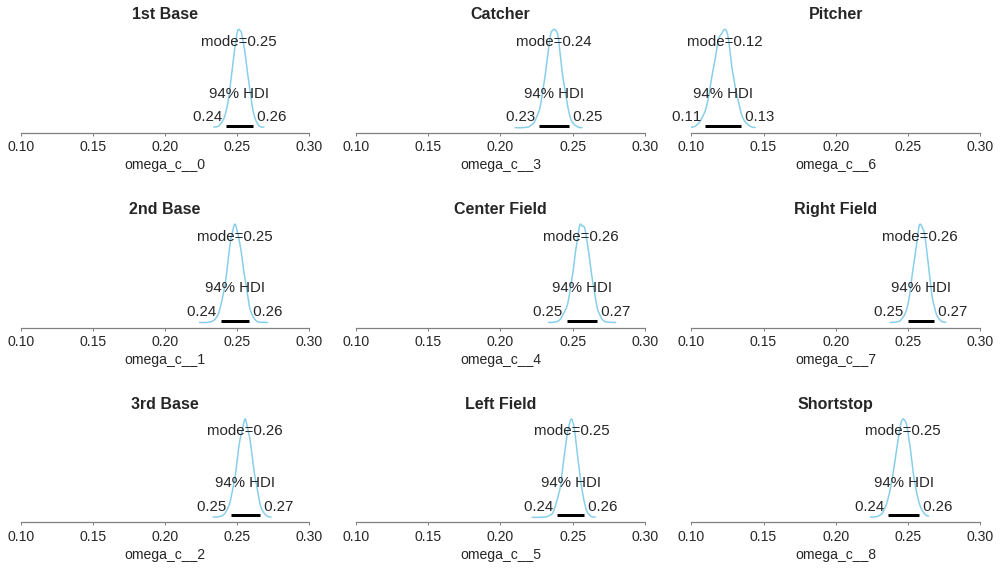

In [44]:
fig, axes = plt.subplots(3,3, figsize=(14,8))

for i, ax in enumerate(axes.T.flatten()):
    az.plot_posterior(idata2.posterior['omega_c'].sel(omega_c_dim_0=i), ax=ax, point_estimate='mode', color=color)
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.10,0.30)

plt.tight_layout(h_pad=3)